In [72]:
# class RobotabilityGraph that inherits from Graph class 
import os
import sys 
sys.path.append("/share/ju/urban-fingerprinting")

import osmnx as ox 
import geopandas as gpd 
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
# enable latex plotting 
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

from glob import glob 
from tqdm import tqdm 

from shapely import wkt, LineString 

import rasterio
from rasterio.enums import Resampling
from rasterio.plot import show 


from src.utils.logger import setup_logger 

logger = setup_logger('robotability-score')
logger.setLevel("INFO")
logger.info("Modules initialized.")

WGS='EPSG:4326'
PROJ='EPSG:2263'

USE_ALTERNATE_GEN_METHOD = True

2025-02-12 14:25:06 - robotability-score - INFO - Modules initialized.


In [73]:
def min_max_normalize(series: pd.Series) -> pd.Series:
    """
    Normalize the input pandas Series using min-max normalization.

    Parameters:
    series (pd.Series): The pandas Series to normalize.

    Returns:
    pd.Series: A new pandas Series with values normalized between 0 and 1.
    """
    min_val = series.min()
    max_val = series.max()
    
    if min_val == max_val:
        # Avoid division by zero; if all values are the same, return 0 for all elements
        return pd.Series([0.0] * len(series), index=series.index)
    
    return (series - min_val) / (max_val - min_val)

In [74]:
dataset = pd.read_csv("../data/processed/score_dataset.csv", engine='pyarrow')
dataset = gpd.GeoDataFrame(dataset, geometry=dataset['geometry'].apply(wkt.loads), crs=PROJ)

In [75]:
len(dataset.index)

1902877

In [76]:
dataset.columns.values

array(['', '5g_technology', '5g_mindown', '5g_minup', '5g_environmnt',
       '5g_h3_res9_id', '4g_technology', '4g_mindown', '4g_minup',
       '4g_environmnt', '4g_h3_res9_id', 'Unnamed: 0', 'width',
       'segment_index', 'geometry', 'point_index', 'ft_above_sea',
       'n_cameras_median', 'Unnamed: 0_street_furniture',
       'width_street_furniture', 'segment_index_street_furniture',
       'geometry_street_furniture', 'bus_stop_count', 'trash_can_count',
       'linknyc_count', 'citybench_count',
       'bicycle_parking_shelter_count', 'bicycle_rack_count',
       'tree_count', 'newsstand_count', 'parking_meter_count',
       'hydrant_count', 'street_sign_count', 'alarm_call_box_count',
       'scaffolding_permit_count', 'clutter', 'ZONEDIST', 'Shape_Leng',
       'Shape_Area', 'distance_to_nearest_station', 'CURBRAMP_count',
       'RAISEDCROSSWALK_count', 'boro_cd', 'shape_area', 'shape_leng',
       'cd_code', 'sidewalk_quality', 'POI_the_geom', 'POI_SEGMENTID',
       'POI_

In [77]:
dataset.isna().sum()  

                                       0
5g_technology                       1592
5g_mindown                          1592
5g_minup                            1592
5g_environmnt                       1592
                                    ... 
sip_corridors_count                 1790
barnes_intersections_count          1790
leading_ped_intervals_count         1790
highest_bike_lane_facility_class    1790
num_peds_involved_in_collision      1790
Length: 75, dtype: int64

In [78]:
FEATURES = { 
    'sidewalk_width': 'Sidewalk Width',
    'pedestrian_density': 'Pedestrian Density',
    'street_furniture_density': 'Density of Street Furniture',
    'sidewalk_roughness': 'Sidewalk Roughness',
    'surface_condition': 'Surface Condition',
    'communication_infrastructure': 'Wireless Communication Infrastructure',
    'slope_gradient': 'Slope Gradient',
    'charging_station_proximity': 'Proximity to Charging Stations',
    'local_attitudes': 'Local Attitudes Towards Robots',
    'curb_ramp_availability': 'Curb Ramp Availability',
    'weather_conditions': 'Weather Conditions',
    'crowd_dynamics': 'Crowd Dynamics',
    'traffic_management': 'Traffic Management Systems',
    'surveillance_coverage': 'Surveillance Coverage',
    'zoning_laws': 'Zoning Laws and Regulation',
    'bike_lane_availability': 'Bike Lane Availability',
    'street_lighting': 'Street Lighting',
    'shade_availability': 'Existence of Shade',
    'gps_signal_strength': 'GPS Signal Strength',
    'pedestrian_flow': 'Pedestrian Flow',
    'bicycle_traffic': 'Bicycle Traffic',
    'vehicle_traffic': 'Vehicle Traffic',
    'digital_map_existence': 'Existence of Detailed Digital Maps',
    'intersection_safety': 'Intersection Safety'
}



In [79]:
len(FEATURES)

24

In [80]:
# which 

In [81]:
# read csv as dict and store in WEIGHTS 
WEIGHTS = pd.read_csv("../survey_processing/feature_weights.csv", index_col=0).to_dict()['Weight']
WEIGHTS

{'sidewalk_width': 0.0680683361363927,
 'pedestrian_density': 0.0944557667500405,
 'street_furniture_density': 0.067521144555113,
 'sidewalk_roughness': 0.0459351420083429,
 'surface_condition': 0.0768293357959319,
 'communication_infrastructure': 0.0584516546931818,
 'slope_gradient': 0.0483223144815313,
 'charging_station_proximity': 0.0253164899310615,
 'curb_ramp_availability': 0.0601029702765427,
 'crowd_dynamics': 0.0762192718947518,
 'traffic_management': 0.0463833389681437,
 'surveillance_coverage': 0.0228127297176597,
 'zoning_laws': 0.0414660103369305,
 'bike_lane_availability': 0.0226037495992804,
 'gps_signal_strength': 0.0483597008110543,
 'bicycle_traffic': 0.0306828236124786,
 'vehicle_traffic': 0.0474544306251074,
 'digital_map_existence': 0.0485078685898746,
 'intersection_safety': 0.0705069212165799}

In [82]:
# get sum of weights 
sum(WEIGHTS.values())

0.9999999999999991

In [83]:
features = pd.DataFrame()

In [84]:
# add geometry to features
features['geometry'] = dataset['geometry']
# add point index to features 
features['point_index'] = dataset['point_index']

### Sidewalk Width 

In [85]:
def PREPROCESS_sidewalk_width(col): 
    # softmax the sidewalk width so that it is between 0 and 1
    col = min_max_normalize(col)

    return col
    

if USE_ALTERNATE_GEN_METHOD:
    dataset['sidewalk_width'] = PREPROCESS_sidewalk_width(dataset['width'])
else: 
    dataset['sidewalk_width'] = PREPROCESS_sidewalk_width(dataset['SHAPE_Width'])

In [86]:
def COMPUTE_sidewalk_width(col, WEIGHTS=WEIGHTS): 
    return col * WEIGHTS['sidewalk_width']


In [87]:
features['sidewalk_width'] = COMPUTE_sidewalk_width(dataset['sidewalk_width'])

### Pedestrian Density 

In [88]:
def PREPROCESS_pedestrian_density(col):
    # softmax the pedestrian density so that it is between 0 and 1
    col = min_max_normalize(col)
    return col

dataset['pedestrian_density'] = PREPROCESS_pedestrian_density(dataset['TRAFFIC_Pedestrian'])

In [89]:
def COMPUTE_pedestrian_density(col, WEIGHTS=WEIGHTS):
    return col * WEIGHTS['pedestrian_density']

In [90]:
features['pedestrian_density'] = COMPUTE_pedestrian_density(dataset['pedestrian_density'])

### Street Furniture Density 

In [91]:
def PREPROCESS_street_furniture_density(col):
    # softmax the street furniture density so that it is between 0 and 1
    col = min_max_normalize(col)
    return col

dataset['street_furniture_density'] = PREPROCESS_street_furniture_density(dataset['clutter'])

In [92]:
def COMPUTE_street_furniture_density(col, WEIGHTS=WEIGHTS):
    return col * WEIGHTS['street_furniture_density']

features['street_furniture_density'] = COMPUTE_street_furniture_density(dataset['street_furniture_density'])

### Sidewalk Roughness 

In [93]:
# SKIP preprocessing, as all values are already 1

In [94]:
def COMPUTE_sidewalk_roughness(col=None, WEIGHTS=WEIGHTS): 
    return 1 * WEIGHTS['sidewalk_roughness']


In [95]:
features['sidewalk_roughness'] = COMPUTE_sidewalk_roughness()

# check out accessmap for this 

### Surface Condition 

In [96]:
def PREPROCESS_surface_condition(col):
    col = min_max_normalize(col)
    col = col.fillna(col.mean())
    return col

dataset['surface_condition'] = PREPROCESS_surface_condition(dataset['sidewalk_quality'])

In [97]:
def COMPUTE_surface_condition(col, WEIGHTS=WEIGHTS):
    return col * WEIGHTS['surface_condition']

features['surface_condition'] = COMPUTE_surface_condition(dataset['surface_condition'])

### Wireless Communication Infrastructure 

In [98]:
# SKIP preprocessing, as all values are already 0 or 1

In [99]:
def COMPUTE_communication_infrastructure(row, WEIGHTS=WEIGHTS): 
    return (1 if (row['4g_minup'] > 0 and row['4g_mindown'] > 0) else 0) * WEIGHTS['communication_infrastructure']

In [100]:
features['communication_infrastructure'] = dataset.apply(lambda row: COMPUTE_communication_infrastructure(row), axis=1)

### Slope Gradient 

In [101]:
from scipy.spatial import cKDTree
import numpy as np
from tqdm import tqdm

def POPULATE_slope_gradient_optimized_with_progress(dataset, WEIGHTS=WEIGHTS):
    # Convert geometries to numpy arrays for faster distance computation
    coords = np.array([[geom.x, geom.y] for geom in dataset['geometry']])
    tree = cKDTree(coords)

    # Initialize an array for slope gradients
    slope_gradients = np.zeros(len(dataset))

    # Precompute distances for each point
    for i, row in tqdm(dataset.iterrows(), total=len(dataset)):
        # Get indices of nearest neighbors within 50 units, excluding the point itself
        distances, indices = tree.query(coords[i], k=10, distance_upper_bound=50)
        
        # Remove invalid indices (those equal to len(coords))
        valid_mask = (indices != len(coords)) & (indices != i)
        valid_indices = indices[valid_mask]
        valid_distances = distances[valid_mask]
        
        # Compute slope gradients
        if len(valid_indices) > 0:
            height_diffs = np.abs(dataset['ft_above_sea'].iloc[valid_indices] - row['ft_above_sea'])
            slopes = height_diffs / valid_distances
            # take absolute value of slope
            slopes = np.abs(slopes)
            slope_gradients[i] = slopes.mean() * WEIGHTS['slope_gradient']

    return slope_gradients


LOCAL_LOAD=False 
if not LOCAL_LOAD: 
    # Apply the optimized function with progress monitoring
    dataset['slope_gradient'] = POPULATE_slope_gradient_optimized_with_progress(dataset)
    dataset[['point_index','slope_gradient']].to_csv("../data/processed/slope_gradient.csv")
else: 
    dataset['slope_gradient'] = pd.read_csv("../data/processed/slope_gradient.csv")['slope_gradient']


100%|██████████| 1902877/1902877 [06:14<00:00, 5082.35it/s]


In [102]:
def POSTPROCESS_slope_gradient(col): 
    # softmax the slope gradient so that it is between 0 and 1
    col = min_max_normalize(col)
    return col

dataset['slope_gradient'] = POSTPROCESS_slope_gradient(dataset['slope_gradient'])

In [103]:
def COMPUTE_slope_gradient(col, WEIGHTS=WEIGHTS): 
    return col * WEIGHTS['slope_gradient']


In [104]:
features['slope_gradient'] = COMPUTE_slope_gradient(dataset['slope_gradient'])

<Axes: >

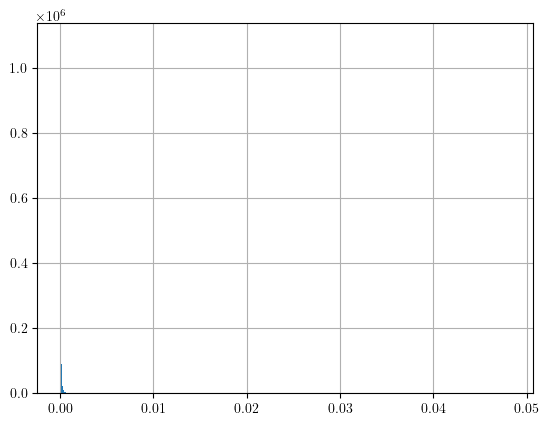

In [105]:
# log the distribution here, as this one might be tricky 
features['slope_gradient'].hist(bins=1000)

### Charging Station Proximity 

In [106]:
# convert to col-level function 
def POPULATE_charging_station_proximity(col, RANGE=max(dataset['distance_to_nearest_station'])): 
    return (RANGE-col)/RANGE

In [107]:
dataset['charging_station_proximity'] = POPULATE_charging_station_proximity(dataset['distance_to_nearest_station'])

In [108]:
def POSTPROCESS_charging_station_proximity(col):
    # softmax the charging station proximity so that it is between 0 and 1
    col = min_max_normalize(col)
    return col

dataset['charging_station_proximity'] = POSTPROCESS_charging_station_proximity(dataset['charging_station_proximity'])

In [109]:
def COMPUTE_charging_station_proximity(col, WEIGHTS=WEIGHTS): 
    return col * WEIGHTS['charging_station_proximity']

features['charging_station_proximity'] = COMPUTE_charging_station_proximity(dataset['charging_station_proximity'])

### Local Attitudes Towards Robots 

**SKIP DUE TO LACK OF DATA** 

### Curb Ramp Availability 

In [110]:
def PREPROCESS_curb_ramp_availability(col): 
    col = min_max_normalize(col)
    return col

dataset['curb_ramp_availability'] = PREPROCESS_curb_ramp_availability(dataset['CURBRAMP_count'])

In [111]:
def COMPUTE_curb_ramp_availability(col, WEIGHTS=WEIGHTS): 
    return col * WEIGHTS['curb_ramp_availability']

features['curb_ramp_availability'] = COMPUTE_curb_ramp_availability(dataset['curb_ramp_availability'])

### Weather Conditions 

** Skip due to hyperlocal/temporal nature of weather conditions ** 

### Crowd Dynamics 

In [112]:
def zonedist_to_indicator(row): 
    
    if row:

        if row.startswith('M'): 
            return 10
        elif row.startswith('R'):
            return 5
        elif row.startswith('C'): 
            return 0
        else: 
            return 2 
    else:
        return 0


def POPULATE_crowd_dynamics(col): 
    return col.apply(zonedist_to_indicator)

dataset['crowd_dynamics'] = POPULATE_crowd_dynamics(dataset['ZONEDIST'])

In [113]:
def POSTPROCESS_crowd_dynamics(col):
    # softmax the crowd dynamics so that it is between 0 and 1
    col = min_max_normalize(col)
    return col

dataset['crowd_dynamics'] = POSTPROCESS_crowd_dynamics(dataset['crowd_dynamics'])

In [114]:
def COMPUTE_crowd_dynamics(col, WEIGHTS=WEIGHTS):
    return col * WEIGHTS['crowd_dynamics']

features['crowd_dynamics'] = COMPUTE_crowd_dynamics(dataset['crowd_dynamics'])

### Traffic Management 

In [115]:
def POPULATE_traffic_management(df, WEIGHTS=WEIGHTS): 
    return  (df['in_slow_zone'] + df['turn_traffic_calming_count'] + df['sip_intersections_count'] + df['sip_corridors_count'] + df['barnes_intersections_count'] + df['leading_ped_intervals_count']).fillna(0)

dataset['traffic_management'] = POPULATE_traffic_management(dataset)





In [116]:
def POSTPROCESS_traffic_management(col): 
    # softmax the traffic management so that it is between 0 and 1
    col = min_max_normalize(col)
    return col

dataset['traffic_management'] = POSTPROCESS_traffic_management(dataset['traffic_management'])
    

In [117]:
def COMPUTE_traffic_management(col, WEIGHTS=WEIGHTS):
    return col * WEIGHTS['traffic_management']

features['traffic_management'] = COMPUTE_traffic_management(dataset['traffic_management'])


### Surveillance Coverage 

In [118]:
def PREPROCESS_surveillance_coverage(col): 
    # softmax the surveillance coverage so that it is between 0 and 1
    col = min_max_normalize(col)
    return col

dataset['surveillance_coverage'] = PREPROCESS_surveillance_coverage(dataset['n_cameras_median'])

In [119]:
def COMPUTE_surveillance_coverage(col, WEIGHTS=WEIGHTS):
    return col * WEIGHTS['surveillance_coverage']

features['surveillance_coverage'] = COMPUTE_surveillance_coverage(dataset['surveillance_coverage'])
    

### Zoning Laws & Regulations

In [120]:
def PREPROCESS_zoning_laws(col): 
    # softmax the zoning laws so that it is between 0 and 1
    col = min_max_normalize(col)
    col = col.fillna(0)
    return col

dataset['zoning_laws'] = PREPROCESS_zoning_laws(dataset['avg_speed_limit'])



In [121]:
def COMPUTE_zoning_laws(col, WEIGHTS=WEIGHTS):
    return col * WEIGHTS['zoning_laws']

features['zoning_laws'] = COMPUTE_zoning_laws(dataset['zoning_laws'])

### Bike Lane Availability 

In [122]:
def PREPROCESS_bike_lane_availability(col):
    # softmax the bike lane availability so that it is between 0 and 1
    col = min_max_normalize(col)
    col = col.fillna(0)
    return col

dataset['bike_lane_availability'] = PREPROCESS_bike_lane_availability(dataset['highest_bike_lane_facility_class'])

In [123]:
def COMPUTE_bike_lane_availability(col, WEIGHTS=WEIGHTS):
    return col * WEIGHTS['bike_lane_availability']

features['bike_lane_availability'] = COMPUTE_bike_lane_availability(dataset['bike_lane_availability'])


### Street Lighting

** Skip due to lack of data ** 

### Shade Availability 

**Come Back**

### GPS Signal Strength

In [124]:
# SKIP preprocessing, as all values are already 0 or 1

In [125]:
def COMPUTE_gps_signal_strenth(col=None, WEIGHTS=WEIGHTS): 
    return 1 * WEIGHTS['gps_signal_strength']

features['gps_signal_strength'] = COMPUTE_gps_signal_strenth()

### Pedestrian Flow 

** Skip due to lack of data ** 

### Bicycle Traffic 

In [126]:
def PREPROCESS_bicycle_traffic(col):
    # softmax the bicycle traffic so that it is between 0 and 1
    col = min_max_normalize(col)
    return col

dataset['bicycle_traffic'] = PREPROCESS_bicycle_traffic(dataset['TRAFFIC_Bike'])


In [127]:
def COMPUTE_bicycle_traffic(col, WEIGHTS=WEIGHTS):
    return col * WEIGHTS['bicycle_traffic']

features['bicycle_traffic'] = COMPUTE_bicycle_traffic(dataset['bicycle_traffic'])

### Vehicle Traffic 

In [128]:
def PREPROCESS_vehicle_traffic(col):
    # softmax the vehicle traffic so that it is between 0 and 1
    col = min_max_normalize(col)
    return col

dataset['vehicle_traffic'] = PREPROCESS_vehicle_traffic(dataset['TRAFFIC_Car'])


In [129]:
def COMPUTE_vehicle_traffic(col, WEIGHTS=WEIGHTS):
    return col * WEIGHTS['vehicle_traffic']

features['vehicle_traffic'] = COMPUTE_vehicle_traffic(dataset['vehicle_traffic'])

### Existence of Detailed Digital Map 

In [130]:
def COMPUTE_ddm():
    return 1 * WEIGHTS['digital_map_existence']

In [131]:
features['digital_map_existence'] = COMPUTE_ddm()

### Intersection Safety 

In [132]:
def PREPROCESS_intersection_safety(col):
    # softmax the intersection safety so that it is between 0 and 1
    col = col.fillna(0).astype(int)
    col = min_max_normalize(col)
    return col

dataset['intersection_safety'] = PREPROCESS_intersection_safety(dataset['num_peds_involved_in_collision'])

In [133]:
def COMPUTE_intersection_safety(col, WEIGHTS=WEIGHTS):

    return col * WEIGHTS['intersection_safety']

features['intersection_safety'] = COMPUTE_intersection_safety(dataset['intersection_safety'])

## SANITY CHECKS

In [134]:
# assert that all values of all columns except geometry and pouint_index are 0-1
for col in features.columns: 
    if col not in ['geometry', 'point_index']: 
        assert features[col].min() >= 0 and features[col].max() <= 1

In [135]:
features.isna().sum() 

geometry                             0
point_index                          0
sidewalk_width                       0
pedestrian_density              330113
street_furniture_density             0
sidewalk_roughness                   0
surface_condition                    0
communication_infrastructure         0
slope_gradient                      88
charging_station_proximity           0
curb_ramp_availability               0
crowd_dynamics                       0
traffic_management                   0
surveillance_coverage                0
zoning_laws                          0
bike_lane_availability               0
gps_signal_strength                  0
bicycle_traffic                 330113
vehicle_traffic                 330113
digital_map_existence                0
intersection_safety                  0
dtype: int64

In [136]:
len(features.columns)

21

In [137]:
# which FEATURES aren't a column in features? 
print(set(FEATURES.keys()) - set(features.columns))


{'weather_conditions', 'local_attitudes', 'street_lighting', 'pedestrian_flow', 'shade_availability'}


In [138]:
POLARITIES = { 
    'sidewalk_width': 1,
    'pedestrian_density': -1,
    'street_furniture_density': -1, 
    'sidewalk_roughness': -1,
    'surface_condition': 1,
    'communication_infrastructure': 1,
    'slope_gradient': -1,
    'charging_station_proximity': 1,
    'local_attitudes': 1,
    'curb_ramp_availability': 1,
    'weather_conditions': 1,
    'crowd_dynamics': 1,
    'traffic_management': 1,
    'surveillance_coverage': 1,
    'zoning_laws': 1,
    'bike_lane_availability': 1,
    'street_lighting': 1,
    'shade_availability': 1,
    'gps_signal_strength': 1,
    'pedestrian_flow': -1,
    'bicycle_traffic': -1,
    'vehicle_traffic': -1,
    'digital_map_existence': 1,
    # num incidents, so more is worse
    'intersection_safety': -1,
}

In [139]:
# score is the aggregation of all features 
features['score'] = features.drop(columns=['geometry', 'point_index']).mul(pd.Series(POLARITIES)).sum(axis=1)



In [140]:
features.describe([0.001, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.975, 0.99, 0.999]) 

,point_index,sidewalk_width,pedestrian_density,street_furniture_density,sidewalk_roughness,surface_condition,communication_infrastructure,slope_gradient,charging_station_proximity,curb_ramp_availability,...,traffic_management,surveillance_coverage,zoning_laws,bike_lane_availability,gps_signal_strength,bicycle_traffic,vehicle_traffic,digital_map_existence,intersection_safety,score
count,1.902877e+06,1.902877e+06,1.572764e+06,1.902877e+06,1.902877e+06,1.902877e+06,1.902877e+06,1.902789e+06,1.902877e+06,1.902877e+06,...,1.902877e+06,1.902877e+06,1.902877e+06,1.902877e+06,1.902877e+06,1.572764e+06,1.572764e+06,1.902877e+06,1.902877e+06,1.902877e+06
mean,9.503240e+05,4.159542e-03,4.086859e-03,4.724888e-03,4.593514e-02,7.041748e-02,5.830934e-02,6.845189e-05,2.104005e-02,1.307109e-03,...,8.606718e-04,1.070670e-03,1.705579e-02,2.290911e-03,4.835970e-02,1.801431e-04,1.451491e-02,4.850787e-02,1.249513e-04,2.437010e-01
std,5.487109e+05,2.467505e-03,6.742958e-03,1.042542e-02,1.387779e-17,9.041608e-03,2.880669e-03,1.639454e-04,4.896988e-03,4.732891e-03,...,2.025369e-03,2.274674e-03,8.123860e-03,5.668449e-03,1.110223e-16,5.286328e-04,5.271297e-03,4.163337e-17,8.459087e-04,2.729564e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.593514e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.835970e-02,0.000000e+00,0.000000e+00,4.850787e-02,0.000000e+00,6.540321e-02
0.1%,1.902876e+03,5.151483e-04,0.000000e+00,0.000000e+00,4.593514e-02,0.000000e+00,0.000000e+00,0.000000e+00,7.203994e-04,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.835970e-02,0.000000e+00,0.000000e+00,4.850787e-02,0.000000e+00,1.333252e-01
1%,1.902476e+04,9.536218e-04,0.000000e+00,0.000000e+00,4.593514e-02,3.074961e-02,5.845165e-02,0.000000e+00,5.417508e-03,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.835970e-02,0.000000e+00,2.063236e-03,4.850787e-02,0.000000e+00,1.693965e-01
2.5%,4.756490e+04,1.291641e-03,0.000000e+00,0.000000e+00,4.593514e-02,5.470571e-02,5.845165e-02,0.000000e+00,8.593985e-03,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.835970e-02,0.000000e+00,3.897224e-03,4.850787e-02,0.000000e+00,1.850346e-01
5%,9.513080e+04,1.627404e-03,0.000000e+00,0.000000e+00,4.593514e-02,5.787899e-02,5.845165e-02,0.000000e+00,1.133756e-02,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.835970e-02,0.000000e+00,5.244613e-03,4.850787e-02,0.000000e+00,1.967449e-01
10%,1.901886e+05,2.046033e-03,0.000000e+00,0.000000e+00,4.593514e-02,6.158861e-02,5.845165e-02,0.000000e+00,1.393863e-02,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.835970e-02,0.000000e+00,7.236724e-03,4.850787e-02,0.000000e+00,2.099116e-01
25%,4.752200e+05,2.807059e-03,2.167660e-04,0.000000e+00,4.593514e-02,6.844917e-02,5.845165e-02,1.667519e-05,1.845418e-02,0.000000e+00,...,0.000000e+00,0.000000e+00,2.073301e-02,0.000000e+00,4.835970e-02,0.000000e+00,1.094412e-02,4.850787e-02,0.000000e+00,2.292813e-01


In [141]:
features['segment_index'] = dataset['segment_index']
features[['point_index','segment_index','geometry','score']].to_csv("../data/processed/score_nyc.csv")

In [142]:
features.to_csv("../data/processed/robotability_features.csv", index=False)